# **Proof of Conecpt**

imports

In [117]:
# general 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import json
from scipy.stats import skewnorm
import seaborn as sns
# ml 
import torch 
# my modules 
import coinbase_order_functions as cb_trade
import dmlstm_trading as dmlstm 
# coinbase 
from coinbase.rest import RESTClient

## **Portfolio and Benchmark**

In [118]:
# portfolio assets and benchamrk
tickers = ['BTC-GBP', 'ETH-GBP', 'SOL-GBP', 'LINK-GBP', 'ADA-GBP'] # because account in gbp, so nop conversion required when making orders 
benchmark_ticker = 'BTC-GBP'

## **Target Returns**

In [119]:
def target_dist_sampler(n_samples, **kwargs): 
    # **kwargs = a, loc, scale
    return skewnorm.rvs(**kwargs, size = n_samples)

## **Get Keys**

In [120]:
path_keys = r'cdp_activate_api_key.json' # relative path of your CDP key
with open(path_keys) as f:
    cb_apis = json.load(f)

# get client
cb_account = cb_trade.CoinbaseTrader(api_key = cb_apis['name'], api_secret = cb_apis['privateKey'])
print('Coinbase Advanced account login status:', cb_account.login())

Coinbase Advanced account login status: True


In [121]:
cb_account.client.get_product('BTC-GBP')['base_max_size']

'200'

## **Validation Functions**

In [122]:
def weight_rebalance(weights: np.ndarray):
    # weight diff **abstract this in equity curve function**
    prior_weights = np.zeros(shape = weights.shape)
    prior_weights[1:, :] = weights[ :-1, :] # from 1st row fill with original array not including last row 
    weight_diff = np.sum(weights - prior_weights, axis = 1)

    return weight_diff

# equity curve function
def equity_curve(returns: np.ndarray, weights, fees = False, fee = 0):
    weight_diff_fees = weight_rebalance(weights)*fee if fees else 0 
    log_returns = np.log(1 + returns - weight_diff_fees)
    sum = np.cumsum(log_returns)
    final_returns = np.exp(sum) -1 

    return final_returns

## **Pre-optimisation Model Results**

In [123]:
# times 
data_frequency = "FOUR_HOUR"
freq = '4h'
data_max = {'hours': 350*4}

# pull data 
dataset_returns = cb_account.coinbase_data(products = tickers, time_frame_candle = data_frequency, freq = freq, **data_max)
dataset_prices = cb_account.coinbase_data(products = tickers, time_frame_candle = data_frequency, get_returns = False, freq = freq, **data_max)
dataset_prices

,BTC-GBP,ETH-GBP,SOL-GBP,LINK-GBP,ADA-GBP
1,83376.22,3333.10,156.31,18.35,0.6353
2,82816.88,3283.59,155.28,18.12,0.6250
3,83326.17,3339.05,158.71,18.63,0.6351
4,82790.18,3326.57,160.73,17.94,0.6320
5,81562.22,3249.25,154.79,17.46,0.6139
...,...,...,...,...,...
345,83435.71,2957.51,145.39,13.41,0.4929
346,83456.11,2946.84,145.40,13.41,0.4913
347,83788.70,2952.58,145.83,13.44,0.4897
348,83850.72,2961.58,144.84,13.58,0.4911


In [124]:
# check dataset shapes are equal
dataset_returns.shape == dataset_prices.shape

True

training and test sets

(array([13., 35., 91., 77., 66., 32., 17., 12.,  5.,  1.]),
 array([-0.03031319, -0.00417687,  0.02195944,  0.04809576,  0.07423207,
         0.10036839,  0.1265047 ,  0.15264102,  0.17877733,  0.20491365,
         0.23104997]),
 <BarContainer object of 10 artists>)

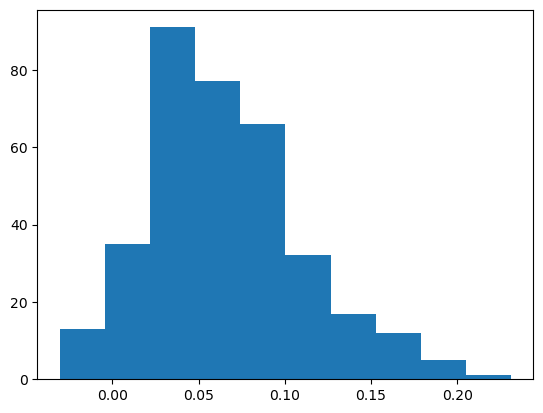

In [125]:
target_returns = target_dist_sampler(n_samples = dataset_returns.shape[0], **{"a": 3, 'loc': 0.01, 'scale': 0.07})

plt.hist(target_returns)

In [126]:
# check shape dimensions match 
print("Dimensions alligned") if target_returns.shape[0] == dataset_returns.iloc[:, 0].shape[0] else print("Dimension mismatch")

Dimensions alligned


In [127]:
# features
returns_train, returns_test = dmlstm.train_test_split_time_series(data = dataset_returns, train_size = 0.65)
prices_train, prices_test = dmlstm.train_test_split_time_series(data = dataset_prices, train_size = 0.65)

# labels 
y_train, y_test = dmlstm.train_test_split_time_series(data = target_returns, train_size = 0.65)

train initial model

In [128]:
lookback = 10
# pre process data 
x_train_tensor, y_train_tensor = dmlstm.prepare_features(asset_returns = returns_train, 
                                                         asset_prices = prices_train, 
                                                         target_returns = y_train, 
                                                         lookback = lookback)

## **Instantiate Model**

In [129]:
# instantiate model
dims = returns_train.shape[1]
dmlstm_model = dmlstm.DmLSTM(input_dim = dims, output_dim = dims, hidden_dim = 64, num_layers = 2)

print("input = (batch_size = m - lookback, sequence length = m, input_size) =",  x_train_tensor.shape)

# predict model
predicted_weights = dmlstm_model(x_train_tensor) # model has little variation fro in-sample prediction, because uniform setting to all parameters
print("output = (batch_size, sequence length = lookback, hidden size) =",  predicted_weights.shape)

input = (batch_size = m - lookback, sequence length = m, input_size) = torch.Size([216, 10, 10])
output = (batch_size, sequence length = lookback, hidden size) = torch.Size([216, 5])


pre-trained model weights

In [130]:
predicted_weights

tensor([[0.2285, 0.1787, 0.1772, 0.2209, 0.1947],
        [0.2319, 0.1766, 0.1760, 0.2214, 0.1940],
        [0.2320, 0.1784, 0.1728, 0.2220, 0.1947],
        ...,
        [0.2330, 0.1791, 0.1792, 0.2177, 0.1910],
        [0.2297, 0.1790, 0.1795, 0.2196, 0.1921],
        [0.2315, 0.1788, 0.1807, 0.2172, 0.1918]], grad_fn=<SliceBackward0>)

## **Train Model**

In [131]:
lookback = 10
res_in_sample = dmlstm.backprop_rnn(asset_returns = returns_train,
                          asset_prices = prices_train, 
                          target_returns = y_train, 
                          lookback = lookback, 
                          show_progress = True, 
                          learning_rate = 0.001, 
                          n_epochs = 100, 
                          num_layers = 2, 
                          hidden_dim = 100, 
                          min_weight_constraint = True, 
                          min_weight_value = 0.05)

# np.round(res['trained_weights'], 3)

  5%|▌         | 5/100 [00:00<00:04, 21.21it/s]

⏳ Training progress | 0.0% | Loss = 7.27340030670166


 14%|█▍        | 14/100 [00:00<00:03, 23.15it/s]

⏳ Training progress | 10.0% | Loss = 7.198030948638916


 23%|██▎       | 23/100 [00:01<00:03, 21.32it/s]

⏳ Training progress | 20.0% | Loss = 7.000913143157959


 32%|███▏      | 32/100 [00:01<00:03, 19.99it/s]

⏳ Training progress | 30.0% | Loss = 6.601280689239502


 43%|████▎     | 43/100 [00:02<00:03, 18.96it/s]

⏳ Training progress | 40.0% | Loss = 6.401276588439941


 53%|█████▎    | 53/100 [00:02<00:02, 18.25it/s]

⏳ Training progress | 50.0% | Loss = 6.161105632781982


 63%|██████▎   | 63/100 [00:03<00:02, 18.20it/s]

⏳ Training progress | 60.0% | Loss = 6.048562526702881


 73%|███████▎  | 73/100 [00:03<00:01, 18.08it/s]

⏳ Training progress | 70.0% | Loss = 5.943355083465576


 83%|████████▎ | 83/100 [00:04<00:00, 17.45it/s]

⏳ Training progress | 80.0% | Loss = 5.8169965744018555


 93%|█████████▎| 93/100 [00:04<00:00, 17.34it/s]

⏳ Training progress | 90.0% | Loss = 5.778564929962158


100%|██████████| 100/100 [00:05<00:00, 18.58it/s]


✅ Model Trained: Training Progress | 100% | Loss = 5.737888813018799


check positivity, minimum value and sum to one constraint are satisfied

In [132]:
print(res_in_sample['trained_weights'])
print(np.sum(res_in_sample['trained_weights'], axis = 1))

[[0.29314667 0.5519277  0.05492567 0.05       0.05      ]
 [0.05       0.05       0.0618412  0.11986452 0.7182943 ]
 [0.05       0.05       0.11513226 0.67722434 0.10764343]
 ...
 [0.8        0.05       0.05       0.05       0.05      ]
 [0.8        0.05       0.05       0.05       0.05      ]
 [0.8        0.05       0.05       0.05       0.05      ]]
[1.         1.         1.0000001  1.         1.         1.
 1.         1.         1.0000001  1.         1.0000001  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.0000001  1.         1.0000001
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99999994 1.         1.
 1.         0.99999994 1.         1.         1.0000001  1.
 1.         1.0000001  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.  

## **In-sample Training Performance**

estimated optimal in-sample weights 

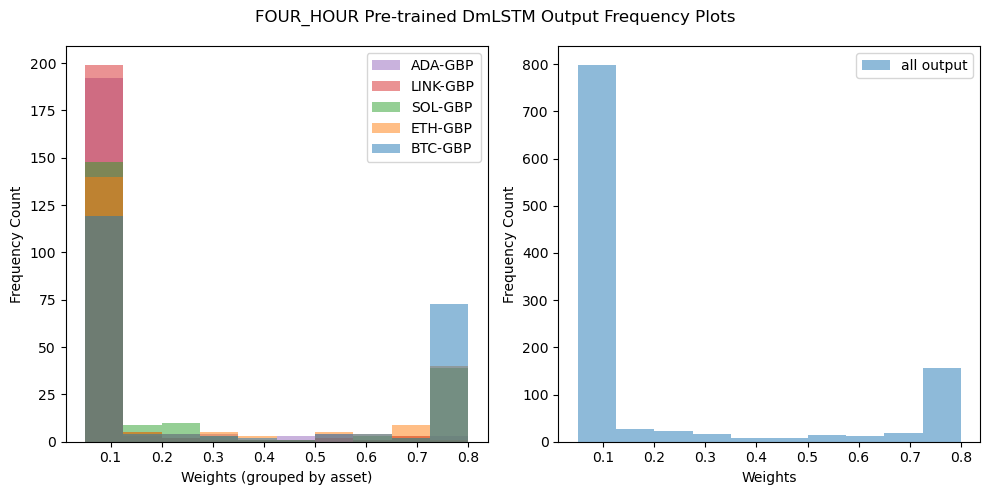

In [133]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 5))
plt.suptitle(f"{data_frequency} Pre-trained DmLSTM Output Frequency Plots")
all_weights = res_in_sample['trained_weights'].reshape(-1, 1).flatten().tolist()
ax[0].hist(res_in_sample['trained_weights'], histtype = 'stepfilled', alpha = 0.5, label = tickers)
ax[0].set_xlabel('Weights (grouped by asset)')
ax[0].set_ylabel('Frequency Count')
ax[0].legend()
ax[1].hist(all_weights, histtype = 'bar', alpha = 0.5, label = 'all output')
ax[1].set_xlabel('Weights')
ax[1].set_ylabel('Frequency Count')
ax[1].legend()
plt.tight_layout();

compare to target return, did we fit well to target

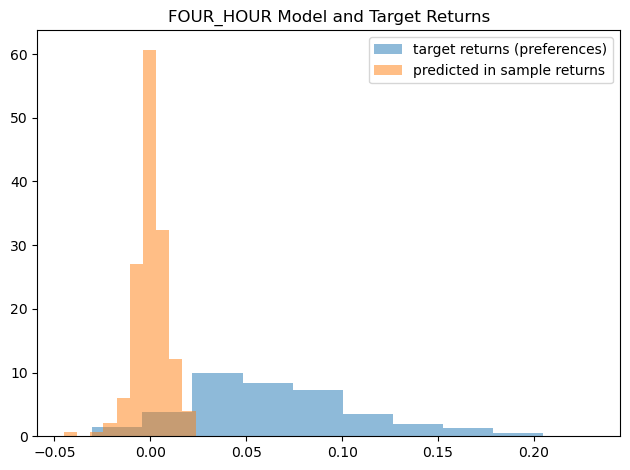

In [134]:
plt.title(f'{data_frequency} Model and Target Returns')
plt.hist(target_returns, alpha = 0.5, label = 'target returns (preferences)', density = True)
plt.hist(res_in_sample['predicted_returns'], alpha = 0.5, label = 'predicted in sample returns', density = True)
plt.legend()
plt.tight_layout();

equity curve performanc. Fees are incoporated in model [1].

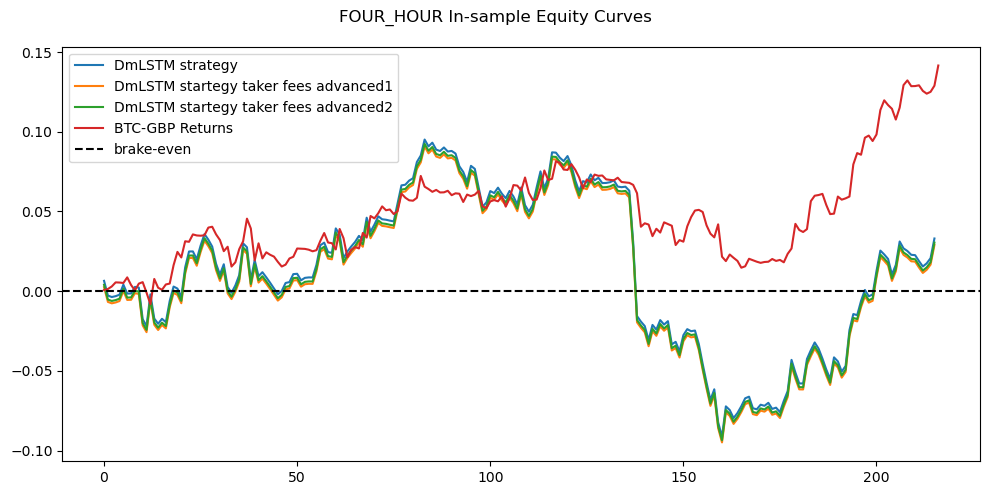

In [135]:
# equity curves 
in_sample_equity_curve = equity_curve(res_in_sample['predicted_returns'], weights = res_in_sample['trained_weights'])
in_sample_equity_curve_fees1 = equity_curve(res_in_sample['predicted_returns'], weights = res_in_sample['trained_weights'], fees = True, fee = 0.40/100)
in_sample_equity_curve_fees2 = equity_curve(res_in_sample['predicted_returns'], weights = res_in_sample['trained_weights'], fees = True, fee = 0.25/100)
in_sample_benchmark_equity_curve = equity_curve(dataset_returns.loc[lookback:len(returns_train), benchmark_ticker].values, weights = res_in_sample['trained_weights'])

# plot 
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle(f"{data_frequency} In-sample Equity Curves")
ax.plot(in_sample_equity_curve, label = "DmLSTM strategy")
ax.plot(in_sample_equity_curve_fees1, label = "DmLSTM startegy taker fees advanced1")
ax.plot(in_sample_equity_curve_fees2, label = "DmLSTM startegy taker fees advanced2")
ax.plot(in_sample_benchmark_equity_curve, label = f"{benchmark_ticker} Returns")
ax.axhline(0, color = 'black', linestyle = "--", label = "brake-even")
ax.legend()
fig.tight_layout();

## **Grid Search**

2 parameter grid search for 
* dimension
* sequence = lookback


In [136]:
# get list of dictionaries with parameters
def grid_search_params(return_data, price_data, target_returns, hidden_dims, lookbacks):
    training_params = []
    for hd in hidden_dims:
        for lkb in lookbacks:
            training_params.append(
                {
                    "asset_returns": return_data,
                    "asset_prices": price_data, 
                    "target_returns": target_returns,
                    "lookback": lkb, 
                    "show_progress": False, 
                    "learning_rate": 0.01, 
                    "n_epochs": 100, 
                    "num_layers": 3, 
                    "hidden_dim": hd, 
                    'min_weight_constraint': True, 
                    'min_weight_value': 0.01,
                }
            )
    
    return training_params

# map function to input iterbale
def run_grid_search(training_params):
    return list(map(lambda input: dmlstm.backprop_rnn(**input), training_params))

# get final returns 
def get_key(return_key, grid_search_output, fees = False, fee = 0):
    final_returns = []
    for res in grid_search_output:
        final_returns.append(
            equity_curve(res[return_key], weights = None, fees = fees, fee = fee)[-1] # get last cumulative return (ROR)
        )
    
    return final_returns


## **Time Frame Grid Search**

In [137]:
# times 
data_frequency = ["FIVE_MINUTE", "FIFTEEN_MINUTE", "ONE_HOUR", "FOUR_HOUR", "ONE_DAY"] # coinbase data length []

freq = ['5min', '15min', '1h', '4h', 'D'] # pd.date_range() date frequency 

data_max = [ 
    {'minutes': 350*5},
    {'minutes': 350*15}, 
    {'hours': 350},
    {'hours': 350*4}, 
    {'days': 350}
] 

# params to search
hidden_dims = range(50, 275, 25)
lookbacks = range(3, 11)

In [138]:
print('total number of simulations in multi-timeframe grid search =', len(hidden_dims) * len(lookbacks) * len(data_frequency))

total number of simulations in multi-timeframe grid search = 360


get target returns per timeframe

In [139]:
min5_target = {"a": 3, 'loc': 0.01, 'scale': 0.04} # 95% all values lie within [-7%, 9%]
min15_target = {"a": 3, 'loc': 0.01, 'scale': 0.05} # 95% all values lie within [-9%, 11%]
h1_target = {"a": 3, 'loc': 0.01, 'scale': 0.06} # 95% all values lie within [-11%, 13%]
h4_target = {"a": 3, 'loc': 0.01, 'scale': 0.07} # 95% all values lie within [-13%, 15%]
d1_target = {"a": 3, 'loc': 0.01, 'scale': 0.08} # 95% all values lie within [-15%, 17%]

target_return_inputs = [min5_target, min15_target, h1_target, h4_target, d1_target]

multi-timeframe grid search function

In [140]:
def run_grid_search_multi_timeframe(target_return_inputs: list, data_frequency: list, freq: list, data_max: list, 
                                    hidden_dims: range, lookbacks: range):
    # initilse params for grid search
    grid_search_returns, grid_search_alpha = [], []
    # save all model outputs in grid search per timeframe 
    ress = {}
    # get training params for grid search per timeframe 
    training_params_tf = {}
    # get out-of-sample data, this is not used in grid search (training data can be accessed via subsetting training params)
    returns_test_tf, priecs_test_tf, target_returns_tf = {}, {}, {}

    for timeframe in range(len(data_frequency)):
        # 
        tf = data_frequency[timeframe]
        # get return and price data 
        data_returns = cb_account.coinbase_data(products = tickers, time_frame_candle = tf, get_returns = True, 
                                                freq = freq[timeframe], **data_max[timeframe])
        data_prices = cb_account.coinbase_data(products = tickers, time_frame_candle = tf, get_returns = False, 
                                                freq = freq[timeframe], **data_max[timeframe])
        
        # get target returns
        target_returns = target_dist_sampler(n_samples = data_returns.shape[0], **target_return_inputs[timeframe])

        # split data (abstract data fetching later)
        training_set_split = 0.65
        returns_train, returns_test = dmlstm.train_test_split_time_series(data = data_returns, train_size = training_set_split)
        returns_test_tf[tf] = returns_test

        prices_train, prices_test = dmlstm.train_test_split_time_series(data = data_prices, train_size = training_set_split)
        priecs_test_tf[tf] = prices_test

        target_returns_train, target_returns_test = dmlstm.train_test_split_time_series(data = target_returns, train_size = training_set_split)
        target_returns_tf[tf] = target_returns_test

        # grid search 
        training_params = grid_search_params(return_data = returns_train, price_data = prices_train, target_returns = target_returns_train, hidden_dims = hidden_dims, lookbacks = lookbacks)
        training_params_tf[tf] = training_params # contains unique datasets 

        res = run_grid_search(training_params = training_params) # runs grid search on model
        ress[tf] = res 

        final_returns = get_key(return_key = 'predicted_returns', grid_search_output = res) # gets model portfolio return estimate and calculates final return 
        grid_search_returns.append(final_returns)

        # construct final return and alpha dataframes
        benchmark_final_return = equity_curve(returns = data_returns.loc[:len(returns_train), benchmark_ticker].values, weights = None)[-1]
        alpha = final_returns - benchmark_final_return
        grid_search_alpha.append(alpha)
    
    return {'all_returns': returns_test_tf,
            'all_prices': priecs_test_tf, 
            'all_target_returns': target_returns_tf,
            'grid_search_final_returns': grid_search_returns, 
            'grid_search_excess_returns': grid_search_alpha, 
            'all_model_inputs': training_params_tf,
            'all_model_outputs': ress}

In [141]:
def grid_search_to_dataframe(hidden_dimentions, lookbacks, final_returns, alphas):  
    # list of all tested params 
    hidden_list = [i for i in hidden_dimentions for j in lookbacks] # loop lookback times and print learning rate 
    lookbacks_list = np.array(lookbacks).tolist() * len(hidden_dimentions) # repeat lookback hidden_list times  

    grouped_final_returns, grouped_alpha = [], []
    for grid_search in range(len(final_returns)):
        # construct final return and alpha dataframe
        grid_search_df = pd.DataFrame({'hidden_layers': hidden_list,
                                'lookbacks': lookbacks_list, 
                                'final_returns': final_returns[grid_search], 
                                'alpha': alphas[grid_search]})
        
        # get dataset of final return values
        grid_search_final_return = grid_search_df.pivot(index = 'hidden_layers', columns = 'lookbacks', values = 'final_returns') # aggragets by index and column
        grid_search_alpha = grid_search_df.pivot(index = 'hidden_layers', columns = 'lookbacks', values = 'alpha')

        grouped_final_returns.append(grid_search_final_return)
        grouped_alpha.append(grid_search_alpha)

    return {'grouped_returns': grouped_final_returns, 
            'grouped_alpha': grouped_alpha}

run multi-timeframe grid-search 

In [142]:
res = run_grid_search_multi_timeframe(target_return_inputs = target_return_inputs, data_frequency = data_frequency, freq = freq, 
                                      data_max = data_max, hidden_dims = hidden_dims, lookbacks = lookbacks)


failed ETH-GBP download
failed SOL-GBP download
failed LINK-GBP download
failed ADA-GBP download
failed ETH-GBP download
failed SOL-GBP download
failed LINK-GBP download
failed ADA-GBP download


100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


get multi-timeframe final returns and alpha data  

In [143]:
multi_data = grid_search_to_dataframe(hidden_dimentions = hidden_dims, lookbacks = lookbacks,
                                      final_returns = res['grid_search_final_returns'], 
                                      alphas = res['grid_search_excess_returns'])

plot grid search final returns for different timeframes 

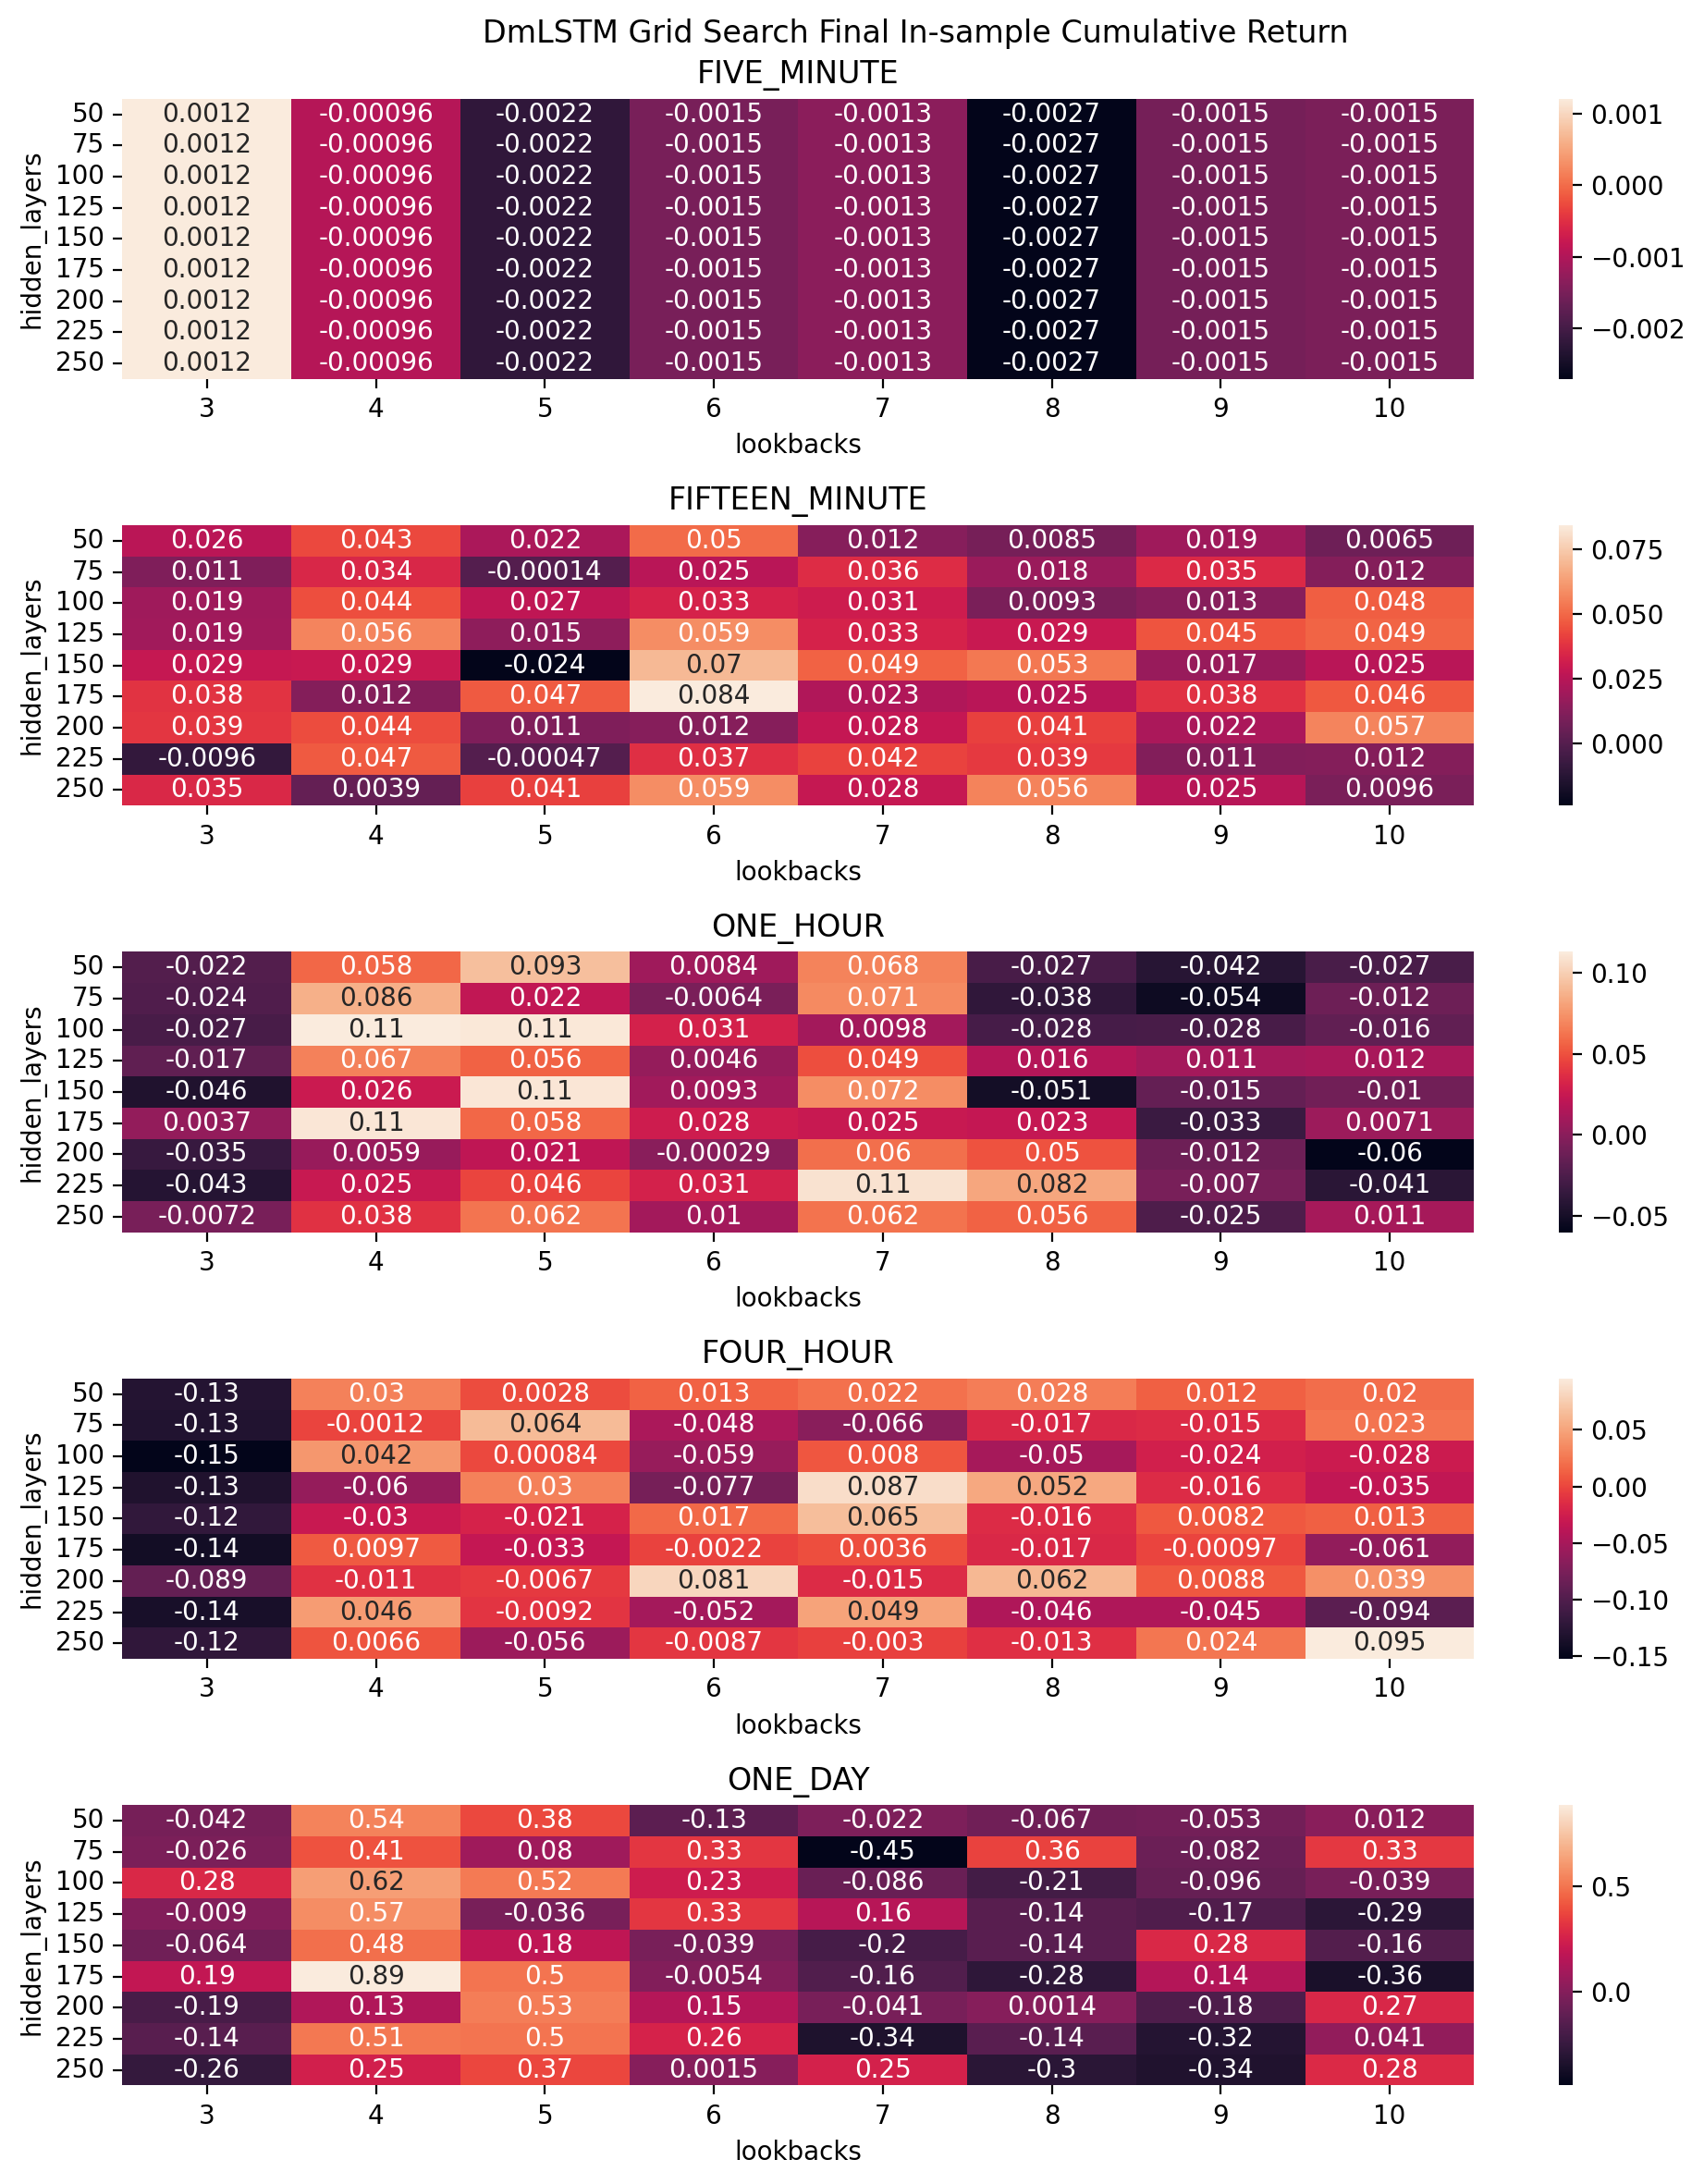

In [144]:
fig, ax = plt.subplots(nrows = len(multi_data['grouped_returns']), ncols = 1, figsize = (10, 12), dpi = 200)
fig.suptitle('DmLSTM Grid Search Final In-sample Cumulative Return')
for idx, data in enumerate(multi_data['grouped_returns']):
    sns.heatmap(data = data, annot = True, ax = ax[idx])
    ax[idx].set_title(f'{data_frequency[idx]}')
fig.tight_layout();

plot grid search of alpha values for different timeframes 

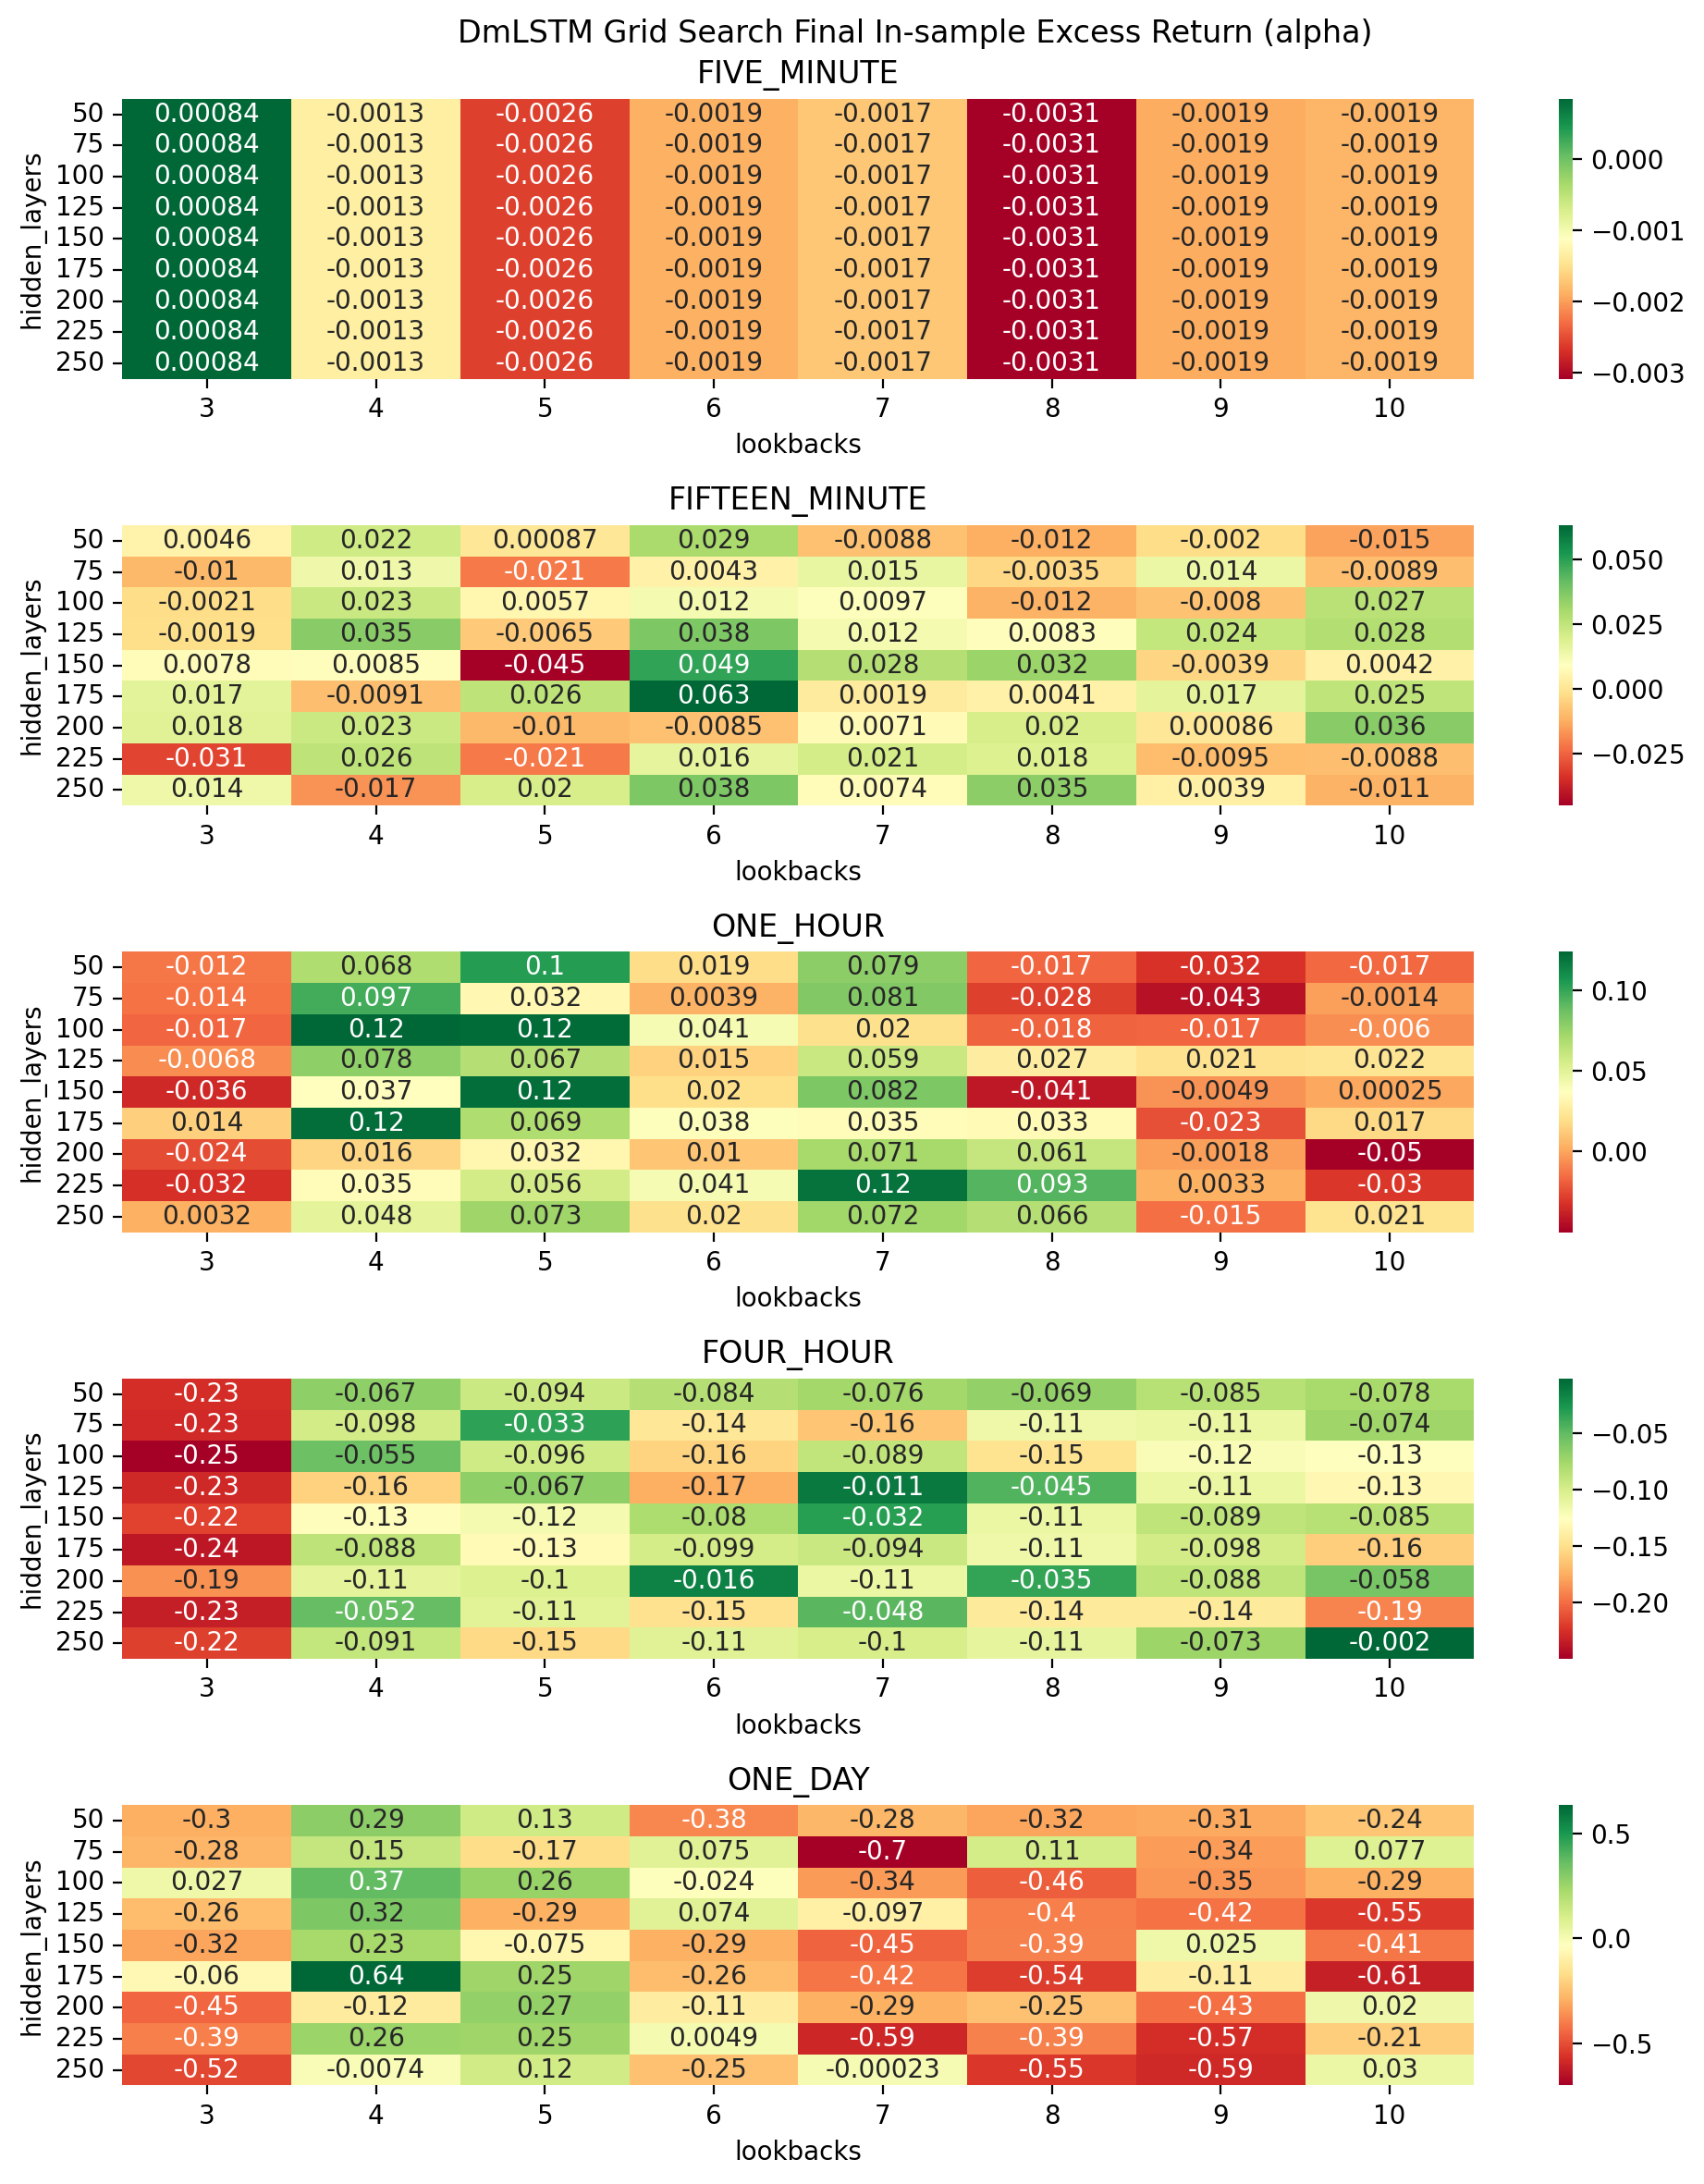

In [145]:
fig, ax = plt.subplots(nrows = len(multi_data['grouped_alpha']), ncols = 1, figsize = (10, 12), dpi = 200)
fig.suptitle('DmLSTM Grid Search Final In-sample Excess Return (alpha)')
for idx, data in enumerate(multi_data['grouped_alpha']):
    sns.heatmap(data = data, annot = True, cmap = "RdYlGn", ax = ax[idx])
    ax[idx].set_title(f'{data_frequency[idx]}')
fig.tight_layout();

## **Single Timeframe Grid-search Model Prediction**

load best performing model from grid search and use it to make predictions on unseen data 

optimal LSTM settings:
* hidden dimensions = []
* lookbacks = []

In [146]:
# chosen params
hidden_dim = 150
lookback = 6

# chosen inputs and res 
chosen_tf = 'ONE_DAY'
training_params = res['all_model_inputs'][chosen_tf]
grid_search_model_output = res['all_model_outputs'][chosen_tf]

# get model index with these params. we have list of dicts 
model_number = None
for indx1, model in enumerate(training_params):
    if training_params[indx1]['hidden_dim'] == hidden_dim and training_params[indx1]['lookback'] == lookback:
        model_number = indx1

# confirm 
print(training_params[model_number]['hidden_dim'])
print(training_params[model_number]['lookback'])

# get 'optimal' model using index 
dmlstm_opt = grid_search_model_output[model_number]['trained_model']  
print(dmlstm_opt)

150
6
DmLSTM(
  (lstm): LSTM(10, 150, num_layers=3, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=150, out_features=5, bias=True)
  (output): Softmax(dim=-1)
)


get model and predict 

In [151]:
# get required data (tets data)
returns_test = res['all_returns'][chosen_tf]
prices_test = res['all_prices'][chosen_tf]
target_returns_test = res['all_target_returns'][chosen_tf]

# pre-process data (cannot abstract as called in the backprop_rnn() function)
x_test_tensor, y_test_tensor = dmlstm.prepare_features(asset_returns = returns_test, 
                                                         asset_prices = prices_test, 
                                                         target_returns = target_returns_test, 
                                                         lookback = lookback)

# pass batch data to forward method of model 
validation_weights = dmlstm_opt(x_test_tensor, use_weight_constraint = True, weight_constraint = 0.01).detach().numpy() # model already instantiated, now just load model

# model asset allocation
# np.round(validation_weights, 3)

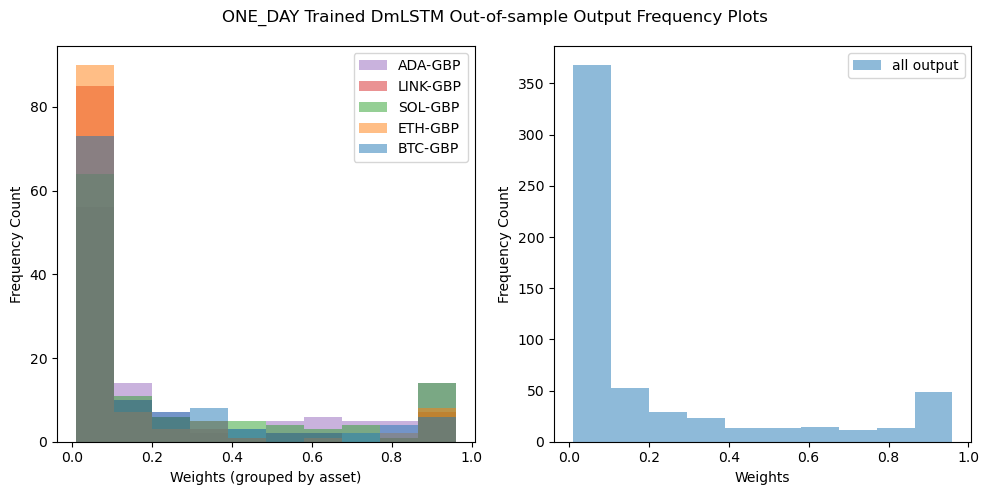

In [152]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (10, 5))
plt.suptitle(f"{chosen_tf} Trained DmLSTM Out-of-sample Output Frequency Plots")
all_weights = validation_weights.reshape(-1, 1).flatten().tolist()
ax[0].hist(validation_weights, histtype = 'stepfilled', alpha = 0.5, label = tickers)
ax[0].set_xlabel('Weights (grouped by asset)')
ax[0].set_ylabel('Frequency Count')
ax[0].legend()
ax[1].hist(all_weights, histtype = 'bar', alpha = 0.5, label = 'all output')
ax[1].set_xlabel('Weights')
ax[1].set_ylabel('Frequency Count')
ax[1].legend()
plt.tight_layout();

## **Single Timeframe Out-of-sample Performance**

to model fees correctley we need to find the fraction of fees from the portfolio weight change per new model prediction and subtract this from the weighted return.

In [153]:
# change first value in returns array to zero/fee value. When strategy beggins trading, this value is not know (avoid forward leak)
returns_test_subset = returns_test[lookback:]
returns_test_subset[0] = -0.35/100 # average of fees (forcasted)

# calculate 
out_sample_returns = np.sum(validation_weights * returns_test_subset, axis = 1)

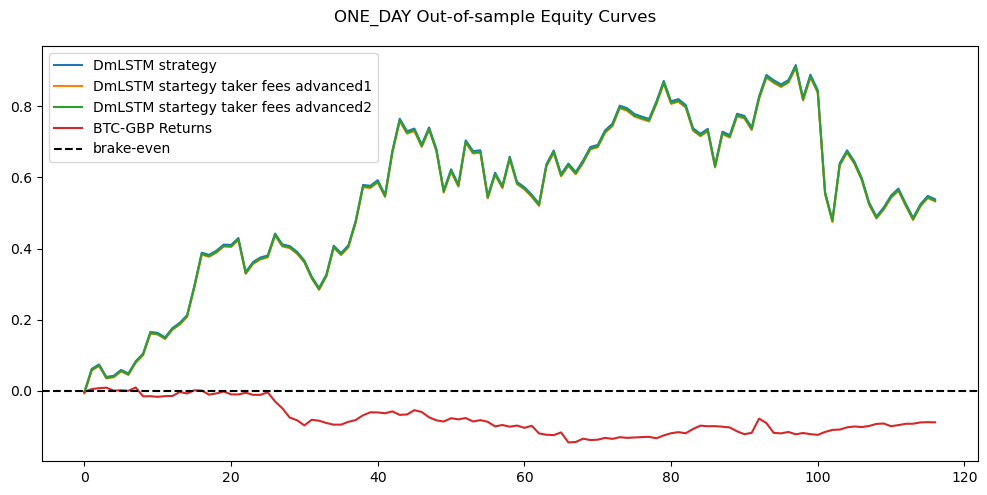

In [154]:
# equity curves 
val_equity_curve = equity_curve(out_sample_returns, weights=validation_weights)
val_equity_curve_fees1 = equity_curve(out_sample_returns, weights = validation_weights, fees = True, fee = 0.40/100)
val_equity_curve_fees2 = equity_curve(out_sample_returns, weights = validation_weights, fees = True, fee = 0.25/100)
benchmark_ticker = 'BTC-GBP'
val_benchmark_equity_curve = equity_curve(dataset_returns.loc[len(returns_train) + 1+lookback:, benchmark_ticker].values, weights = validation_weights)

# plot 
fig, ax = plt.subplots(figsize = (10, 5))
fig.suptitle(f"{chosen_tf} Out-of-sample Equity Curves")
ax.plot(val_equity_curve, label = "DmLSTM strategy")
ax.plot(val_equity_curve_fees1, label = "DmLSTM startegy taker fees advanced1")
ax.plot(val_equity_curve_fees2, label = "DmLSTM startegy taker fees advanced2")
ax.plot(val_benchmark_equity_curve, label = f"{benchmark_ticker} Returns")
ax.axhline(0, color = 'black', linestyle = "--", label = "brake-even")
ax.legend()
fig.tight_layout();

## **Appendix**

[1] - [Coinbase Taker/Maker Spot Fees](https://www.coinbase.com/advanced-fees) $\\$